# Uso de la GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")


1 GPU(s) física(s), 1 GPU(s) lógica(s)


In [20]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
tf.__version__

'2.10.1'

# Pip install

In [8]:
pip install tensorflow_addons

  Using cached tensorflow_addons-0.22.0-cp310-cp310-win_amd64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.22.0-cp310-cp310-win_amd64.whl (719 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install vit-keras

Using cached vit_keras-0.1.2-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
Note: you may need to restart the kernel to use updated packages.


# Imports

In [13]:
import os 
import requests
from zipfile import ZipFile 
import shutil 
import pandas as pd 
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split 
from collections import Counter 
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from tensorflow.keras.callbacks import TensorBoard 
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


import pandas as pd
import tensorflow_addons
from vit_keras import vit 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L


from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
 

In [14]:
import random, os
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Creación del dataframe mediante la ubicación y el label

In [15]:
data_dir = 'data' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obitene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



traindataframe = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [19]:
traindataframe

,filepath,labels
0,data\angry\aug_0_0.jpeg,angry
1,data\angry\aug_0_1.jpeg,angry
2,data\angry\aug_0_10.jpeg,angry
3,data\angry\aug_0_100.jpeg,angry
4,data\angry\aug_0_1000.jpeg,angry
...,...,...
59495,data\surprise\Training_99916297.jpg,surprise
59496,data\surprise\Training_99924420.jpg,surprise
59497,data\surprise\Training_99937001.jpg,surprise
59498,data\surprise\Training_99951755.jpg,surprise


# División del train, val y test

In [16]:
#Se divide el dataset en train, test y val
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(traindataframe, test_size=0.1, stratify=traindataframe['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

train_df, test_df, val_df

(                                 filepath    labels
 29740    data\happy\Training_46880224.jpg     happy
 43976            data\sad\aug_0_4725.jpeg       sad
 10690        data\disgust\aug_0_3523.jpeg   disgust
 42001  data\neutral\Training_91168774.jpg   neutral
 49999      data\sad\Training_80899611.jpg       sad
 ...                                   ...       ...
 52632       data\surprise\aug_0_3897.jpeg  surprise
 38611  data\neutral\Training_28817271.jpg   neutral
 27217    data\happy\Training_15365662.jpg     happy
 43661            data\sad\aug_0_3893.jpeg       sad
 30000    data\happy\Training_49997455.jpg     happy
 
 [42840 rows x 2 columns],
                                filepath   labels
 36975      data\neutral\aug_0_8518.jpeg  neutral
 14171      data\disgust\aug_0_7487.jpeg  disgust
 31440   data\happy\Training_6815367.jpg    happy
 15978      data\disgust\aug_0_9549.jpeg  disgust
 13398      data\disgust\aug_0_6605.jpeg  disgust
 ...                               

# Generación de iteradores con ImageDataGenerator

In [55]:
image_size = 224
batch_size = 128
n_classes = 7
EPOCHS = 15

In [56]:


train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,  # Rango de rotación más conservador
                                    zoom_range=0.2,     # Rango de zoom más conservador
                                    width_shift_range=0.2,  # Desplazamiento horizontal más conservador
                                    height_shift_range=0.2,  # Desplazamiento vertical más conservador
                                    shear_range=0.2,     # Variaciones en la inclinación facial más conservadoras
                                    brightness_range=[0.8, 1.2],  # Cambios de brillo realistas
                                    horizontal_flip=True,
                                    vertical_flip=True,  # Volteo vertical aleatorio
                                    fill_mode='nearest')  # Modo de relleno)

#test_datagen=  ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df, #ubicación de train
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(image_size,image_size),
    shuffle = True,
    seed = 42

)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(image_size,image_size),
    shuffle = False,
    seed = 42
    
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(image_size,image_size),
    shuffle = False,
    seed = 42
)

Found 42840 validated image filenames belonging to 7 classes.
Found 10710 validated image filenames belonging to 7 classes.
Found 5950 validated image filenames belonging to 7 classes.


# Definición de patches

In [22]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Aplicación de patches en la imágen

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


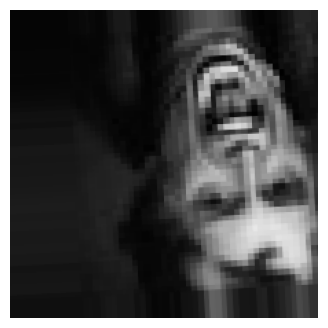

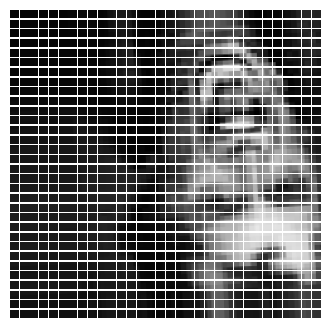

In [23]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  
num_patches = (image_size // patch_size) ** 2

x = train_generator.next()
image = x[0][0]
image = (image * 255).astype('uint8') # Escalar los valores de píxeles de 0-1 a 0-255

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

# Creación y definición del modelo Transformers Vit/B16

In [70]:
from vit_keras import vit

vit_model = vit.vit_b16( #Definición del modelo vit_keras
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 7)

In [66]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [74]:
# Congelar los pesos del modelo ViT
for layer in vit_model.layers:
    layer.trainable = False

#Definición del modelo vit_keras + Fine-Tuning
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(7, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

model.compile(optimizer = "adam", 
              loss = "categorical_crossentropy", 
              metrics = ['accuracy'])


model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_27 (Flatten)        (None, 768)               0         
                                                                 
 batch_normalization_34 (Bat  (None, 768)              3072      
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 128)               98432     
                                                                 
 batch_normalization_35 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_62 (Dense)            (None, 64)         

In [75]:
os.makedirs('models/ModelTransformer/', exist_ok=True)


checkpoint_path = 'models/ModelTransformer/best_model_ModelVIt_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [76]:
historyVit = model.fit(x = train_generator,
          steps_per_epoch = len(train_generator),
          validation_data = val_generator,
          epochs = 25,
          callbacks = [early_stopping, model_checkpoint])

Epoch 1/25
335/335 [==============================] - ETA: 0s - loss: 1.5668 - accuracy: 0.3977
Epoch 1: val_accuracy improved from -inf to 0.48067, saving model to models/ModelTransformer\best_model_ModelVIt_1_0.4807.h5
335/335 [==============================] - 982s 3s/step - loss: 1.5668 - accuracy: 0.3977 - val_loss: 1.3579 - val_accuracy: 0.4807
Epoch 2/25
335/335 [==============================] - ETA: 0s - loss: 1.4360 - accuracy: 0.4500
Epoch 2: val_accuracy improved from 0.48067 to 0.50915, saving model to models/ModelTransformer\best_model_ModelVIt_2_0.5092.h5
335/335 [==============================] - 921s 3s/step - loss: 1.4360 - accuracy: 0.4500 - val_loss: 1.2986 - val_accuracy: 0.5092
Epoch 3/25
335/335 [==============================] - ETA: 0s - loss: 1.3969 - accuracy: 0.4646
Epoch 3: val_accuracy improved from 0.50915 to 0.51261, saving model to models/ModelTransformer\best_model_ModelVIt_3_0.5126.h5
335/335 [==============================] - 921s 3s/step - loss: 1.3

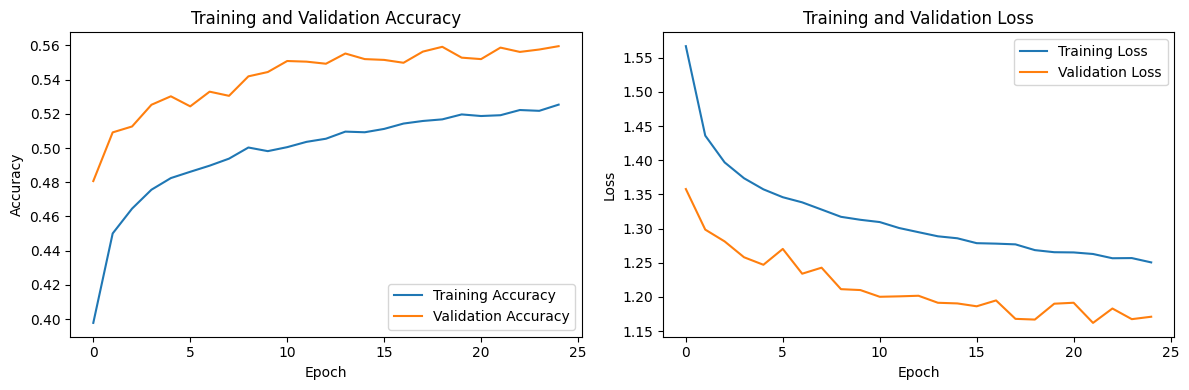

In [77]:
import matplotlib.pyplot as plt


accuracy = historyVit.history['accuracy']
loss = historyVit.history['loss']
val_accuracy = historyVit.history['val_accuracy']
val_loss = historyVit.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
predicted_classes = np.argmax(model.predict(test_generator, steps = test_generator.n // test_generator.batch_size + 1), axis = 1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  


print(classification_report(true_classes, predicted_classes))

47/47 [==============================] - 53s 1s/step
              precision    recall  f1-score   support

           0       0.39      0.41      0.40       850
           1       0.73      0.82      0.77       850
           2       0.44      0.26      0.33       850
           3       0.73      0.73      0.73       850
           4       0.45      0.59      0.51       850
           5       0.49      0.27      0.35       850
           6       0.58      0.80      0.68       850

    accuracy                           0.56      5950
   macro avg       0.55      0.56      0.54      5950
weighted avg       0.55      0.56      0.54      5950

